**Introduction**

Machine Learning algorithms have become an increasingly important tool for analyzing the data from the Large Hadron Collider (LHC). Identification of particles in LHC collisions is an important task of LHC detector reconstruction algorithms.

Here we present a challenge where one of the detectors (the Electromagnetic Calorimeter or ECAL) is used as a camera to analyze detector images from two types of particles: electrons and photons that deposit their energy in this detector.

**Dataset**

Each pixel in the image corresponds to a detector cell, while the intensity of the pixel corresponds to how much energy is measured in that cell. Timing of the energy deposits are also available, though this may or may not be relevant. The dataset contains 32x32 Images of the energy hits and their timing (channel 1: hit energy and channel 2: its timing) in each calorimeter cell (one cell = one pixel) for the two classes of particles: Electrons and Photons. The dataset contains around four hundred thousand images for electrons and photons. Please note that your final model will be evaluated on an unseen test dataset.

**Algorithm**

Please use a Machine Learning model of your choice to achieve the highest possible classification performance on the provided dataset. Please provide a Jupyter Notebook that shows your solution.

Evaluation Metrics
ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve)
Training and Validation Accuracy
The model performance will be tested on a hidden test dataset based on the above metrics.


## Create the appropriate project folder 

In [1]:
mkdir Particle_Images

In [1]:
cd Particle_Images

C:\Users\shambhu\Desktop\Projects\PH482_582\Particle_Images


In [3]:
mkdir data/

# Download the Dataset

In [ ]:
#!/bin/bash
!wget https://cernbox.cern.ch/index.php/s/69nGEZjOy3xGxBq/download -O data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5

# Import modules

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import h5py
np.random.seed(1337)  # for reproducibility
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [3]:
import numpy as np
np.random.seed(1337)  # for reproducibility
import h5py
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation, GlobalAvgPool2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_curve, auc, accuracy_score

import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf
tf.__version__

'2.1.0'

# Keras Model Parameters

In [13]:
lr_init     = 1.e-3    # Initial learning rate  
batch_size  = 64       # Training batch size
train_size  = 16000     # Training size
valid_size  = 1000     # Validation size
test_size   = 1000     # Test size
epochs      = 20       # Number of epochs
doGPU       = True    # Use GPU

## It is recommended to use GPU for training and inference if possible.

In [15]:
if doGPU:
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth=True
    set_session(tf.compat.v1.Session(config=config))

# Load Image Data
### Two classes of particles: electrons and photons
### 32x32 matrices (two channels - hit energy and time) for the two classes of particles electrons and photons impinging on a calorimeter (one calorimetric cell = one pixel).
#### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

In [6]:
img_rows, img_cols, nb_channels = 32, 32, 2        
input_dir = 'data'
decays = ['SinglePhotonPt50_IMGCROPS_n249k_RHv1_gzip', 'SingleElectronPt50_IMGCROPS_n249k_RHv1_gzip']

def load_data(decays, start, stop):
    global input_dir
    dsets = [h5py.File('%s/%s.hdf5'%(input_dir,decay)) for decay in decays]
    X = np.concatenate([dset['/X'][start:stop] for dset in dsets])
    y = np.concatenate([dset['/y'][start:stop] for dset in dsets])
    assert len(X) == len(y)
    return X, y

# Configure Training / Validation / Test Sets

In [14]:
# Set range of training set
train_start, train_stop = 0, train_size
assert train_stop > train_start
assert (len(decays)*train_size) % batch_size == 0
X_train, y_train = load_data(decays,train_start,train_stop)

# Set range of validation set
valid_start, valid_stop = 160000, 160000+valid_size
assert valid_stop  >  valid_start
assert valid_start >= train_stop
X_valid, y_valid = load_data(decays,valid_start,valid_stop)

# Set range of test set
test_start, test_stop = 180000, 180000+test_size
assert test_stop  >  test_start
assert test_start >= valid_stop
X_test, y_test = load_data(decays,test_start,test_stop)

samples_requested = len(decays) * (train_size + valid_size + test_size)
samples_available = len(y_train) + len(y_valid) + len(y_test)
assert samples_requested == samples_available

C:\Users\shambhu\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  import sys


In [15]:
X_train_1 = X_train[:,:,:,0]
X_valid_1 = X_valid[:,:,:,0]
X_train_1 = X_train_1[...,np.newaxis]
X_valid_1 = X_valid_1[...,np.newaxis]
X_test_1 = X_test[:,:,:,0]
X_test_1 = X_test_1[...,np.newaxis]
X_train_1.shape

(32000, 32, 32, 1)

# Plot sample of training images
### Please note that although timing channel is provided, it may not necessarily help the performance of the model.

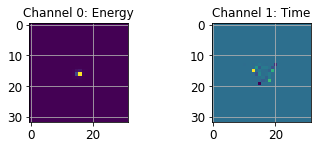

In [9]:
plt.figure(1)

plt.subplot(221)
plt.imshow(X_train[40,:,:,0])
plt.title("Channel 0: Energy")  # Energy
plt.grid(True)

plt.subplot(222)
plt.imshow(X_train[1,:,:,1])
plt.title("Channel 1: Time")  # Time
plt.grid(True)


plt.show()

# Model 1: LeNet

This is a LeNet architecture with some modifications.

In [9]:
tensorflow.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', input_shape=(img_rows, img_cols,2)))
model.add(BatchNormalization())
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal'))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])

In [10]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1.e-6)

history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Train on 32000 samples, validate on 2000 samples
Epoch 1/20
32000/32000 [==============================] - 13s 410us/sample - loss: 0.7350 - accuracy: 0.5369 - val_loss: 0.7640 - val_accuracy: 0.5005
Epoch 2/20
32000/32000 [==============================] - 9s 274us/sample - loss: 0.6796 - accuracy: 0.5799 - val_loss: 0.6704 - val_accuracy: 0.5825
Epoch 3/20
32000/32000 [==============================] - 9s 271us/sample - loss: 0.6637 - accuracy: 0.6022 - val_loss: 0.6661 - val_accuracy: 0.5830
Epoch 4/20
32000/32000 [==============================] - 9s 274us/sample - loss: 0.6538 - accuracy: 0.6181 - val_loss: 0.6981 - val_accuracy: 0.5360
Epoch 5/20
32000/32000 [==============================] - 9s 271us/sample - loss: 0.6475 - accuracy: 0.6268 - val_loss: 0.6650 - val_accuracy: 0.5880
Epoch 6/20
32000/32000 [==============================] - 9s 271us/sample - loss: 0.6399 - accuracy: 0.6346 - val_loss: 0.6509 - val_accuracy: 0.6230
Epoch 7/20
32000/32000 [==========================

In [16]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

2000/2000 [==============================] - 0s 193us/sample - loss: 0.6345 - accuracy: 0.6725

Validation loss / accuracy: 0.6345 / 0.6725
Validation ROC AUC: 0.73543
2000/2000 [==============================] - 0s 173us/sample - loss: 0.6159 - accuracy: 0.7000

Test loss / accuracy: 0.6159 / 0.7000
Test ROC AUC: 0.749857


In [117]:
model.save("hack_02_model.h5")

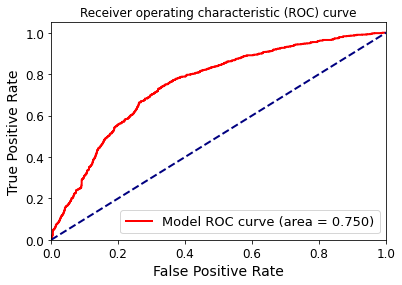

In [17]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Model ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

# Model 2: Changing the filter size in the above model

This model is trained by using the best learning parameters obtained by using RandomizedsearchCV, which is shown below.

In [15]:

model = Sequential()
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01), input_shape=(img_rows, img_cols, 2)))
model.add(BatchNormalization())
model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Conv2D(64, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01992351943721117), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        304       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)       

Train the model

In [121]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=2, min_lr=1.e-6)
history=model.fit(X_train, y_train,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Train on 256000 samples, validate on 10000 samples
Epoch 1/20
256000/256000 [==============================] - 107s 420us/sample - loss: 1.4912 - accuracy: 0.5102 - val_loss: 1.2023 - val_accuracy: 0.5012
Epoch 2/20
256000/256000 [==============================] - 105s 410us/sample - loss: 1.1754 - accuracy: 0.5058 - val_loss: 1.0098 - val_accuracy: 0.5000
Epoch 3/20
256000/256000 [==============================] - 106s 415us/sample - loss: 1.1443 - accuracy: 0.5071 - val_loss: 0.8357 - val_accuracy: 0.5000
Epoch 4/20
256000/256000 [==============================] - 108s 421us/sample - loss: 1.1204 - accuracy: 0.5074 - val_loss: 0.9770 - val_accuracy: 0.5000
Epoch 5/20
256000/256000 [==============================] - 108s 424us/sample - loss: 1.1375 - accuracy: 0.5070 - val_loss: 1.6272 - val_accuracy: 0.5000
Epoch 6/20
256000/256000 [==============================] - 110s 430us/sample - loss: 0.6922 - accuracy: 0.6268 - val_loss: 4.5997 - val_accuracy: 0.5000
Epoch 7/20
256000/256000 

Evaluate the model

In [98]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

4000/4000 [==============================] - 1s 233us/sample - loss: 0.5825 - accuracy: 0.7143

Validation loss / accuracy: 0.5825 / 0.7143
Validation ROC AUC: 0.777117625
4000/4000 [==============================] - 1s 154us/sample - loss: 0.5898 - accuracy: 0.7078

Test loss / accuracy: 0.5898 / 0.7078
Test ROC AUC: 0.7684195


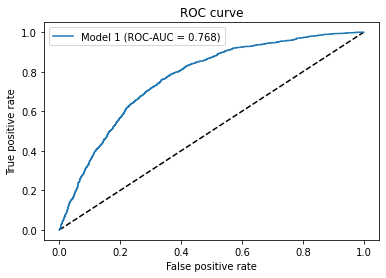

In [99]:
plt.plot([0, 1], [0, 1], 'k--')
#plt.legend(loc=2, prop={'size': 15})
plt.plot(fpr, tpr, label='Model 1 (ROC-AUC = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

There is no significant improvement in the model performance even after using the optimized parameters.

# Grid search for best learning rate

This is hyperparameter tuning is for the model 2 shown above.

In [5]:

def build_model(lr_init=1.e-3, factors = 0.1):
    model = Sequential()
    model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01), input_shape=(img_rows, img_cols, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(16, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, activation='relu', kernel_size=3, padding='same', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid', kernel_initializer='glorot_normal', kernel_regularizer= keras.regularizers.l2(0.01)))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=factors, patience=2, min_lr=1.e-6)
    
    return model
    

In [85]:
cnn_wrap = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [86]:
from scipy.stats import reciprocal
#def exponential_decay(lr_init, s):
#  def exponential_decay_fn(epoch):
#    return lr_init * 0.1**(epoch/s)
#  return exponential_decay_fn
param_distribs = {
    "factors":[0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6],
    "lr_init":reciprocal(3e-4,3e-2)
}


rnd_search_cv = RandomizedSearchCV(cnn_wrap, param_distribs, cv = 3)
  
rnd_search_cv.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Train on 21333 samples, validate on 4000 samples
Epoch 1/20
21333/21333 [==============================] - 10s 475us/sample - loss: 5.5601 - accuracy: 0.6522 - val_loss: 3.6202 - val_accuracy: 0.5000
Epoch 2/20
21333/21333 [==============================] - 7s 338us/sample - loss: 2.3192 - accuracy: 0.7358 - val_loss: 1.9886 - val_accuracy: 0.5000
Epoch 3/20
21333/21333 [==============================] - 7s 340us/sample - loss: 1.3884 - accuracy: 0.7437 - val_loss: 1.4966 - val_accuracy: 0.5000
Epoch 4/20
21333/21333 [==============================] - 7s 340us/sample - loss: 0.9862 - accuracy: 0.7498 - val_loss: 1.2798 - val_accuracy: 0.5000
Epoch 5/20
21333/21333 [==============================] - 7s 341us/sample - loss: 0.7875 - accuracy: 0.7516 - val_loss: 1.1469 - val_accuracy: 0.5002
Epoch 6/20
21333/21333 [==============================] - 7s 339us/sample - loss: 0.6955 - accuracy: 0.7516 - val_loss: 1.1607 - val_accuracy: 0.5000
Epoch 7/20
21333/21333 [==========================

21334/21334 [==============================] - 7s 329us/sample - loss: 0.6180 - accuracy: 0.7484 - val_loss: 0.8399 - val_accuracy: 0.5000
Epoch 5/20
21334/21334 [==============================] - 7s 326us/sample - loss: 0.6005 - accuracy: 0.7480 - val_loss: 0.8392 - val_accuracy: 0.5000
Epoch 6/20
21334/21334 [==============================] - 7s 344us/sample - loss: 0.5868 - accuracy: 0.7495 - val_loss: 0.8067 - val_accuracy: 0.5000
Epoch 7/20
21334/21334 [==============================] - 7s 340us/sample - loss: 0.5982 - accuracy: 0.7478 - val_loss: 0.7711 - val_accuracy: 0.5000
Epoch 8/20
21334/21334 [==============================] - 7s 330us/sample - loss: 0.5778 - accuracy: 0.7486 - val_loss: 0.8015 - val_accuracy: 0.5000
Epoch 9/20
21334/21334 [==============================] - 7s 331us/sample - loss: 0.5896 - accuracy: 0.7489 - val_loss: 0.7597 - val_accuracy: 0.5000
Epoch 10/20
21334/21334 [==============================] - 7s 329us/sample - loss: 0.5857 - accuracy: 0.7497 - 

21333/21333 [==============================] - 7s 325us/sample - loss: 0.7218 - accuracy: 0.6143 - val_loss: 0.7089 - val_accuracy: 0.6155
Epoch 8/20
21333/21333 [==============================] - 7s 328us/sample - loss: 0.7013 - accuracy: 0.6152 - val_loss: 0.7063 - val_accuracy: 0.6077
Epoch 9/20
21333/21333 [==============================] - 7s 327us/sample - loss: 0.6875 - accuracy: 0.6227 - val_loss: 0.6854 - val_accuracy: 0.6200
Epoch 10/20
21333/21333 [==============================] - 7s 329us/sample - loss: 0.6764 - accuracy: 0.6307 - val_loss: 0.7091 - val_accuracy: 0.5585
Epoch 11/20
21333/21333 [==============================] - 7s 326us/sample - loss: 0.6724 - accuracy: 0.6387 - val_loss: 0.7292 - val_accuracy: 0.5580
Epoch 12/20
21333/21333 [==============================] - 7s 328us/sample - loss: 0.6485 - accuracy: 0.6610 - val_loss: 0.6907 - val_accuracy: 0.5945
Epoch 13/20
21333/21333 [==============================] - 7s 327us/sample - loss: 0.6388 - accuracy: 0.6695

21333/21333 [==============================] - 7s 338us/sample - loss: 0.5490 - accuracy: 0.7644 - val_loss: 0.9434 - val_accuracy: 0.5008
Epoch 11/20
21333/21333 [==============================] - 7s 341us/sample - loss: 0.5248 - accuracy: 0.7689 - val_loss: 1.0127 - val_accuracy: 0.5025
Epoch 12/20
21333/21333 [==============================] - 7s 341us/sample - loss: 0.5042 - accuracy: 0.7785 - val_loss: 0.6811 - val_accuracy: 0.6053
Epoch 13/20
21333/21333 [==============================] - 7s 339us/sample - loss: 0.4961 - accuracy: 0.7813 - val_loss: 0.6458 - val_accuracy: 0.6610
Epoch 14/20
21333/21333 [==============================] - 7s 346us/sample - loss: 0.4926 - accuracy: 0.7835 - val_loss: 0.6576 - val_accuracy: 0.6405
Epoch 15/20
21333/21333 [==============================] - 7s 350us/sample - loss: 0.4898 - accuracy: 0.7834 - val_loss: 0.6960 - val_accuracy: 0.6058
Epoch 16/20
21333/21333 [==============================] - 7s 341us/sample - loss: 0.4838 - accuracy: 0.78

21334/21334 [==============================] - 8s 366us/sample - loss: 0.5607 - accuracy: 0.7496 - val_loss: 1.3508 - val_accuracy: 0.5000
Epoch 14/20
21334/21334 [==============================] - 8s 366us/sample - loss: 0.5330 - accuracy: 0.7460 - val_loss: 0.8112 - val_accuracy: 0.5000
Epoch 15/20
21334/21334 [==============================] - 8s 367us/sample - loss: 0.5169 - accuracy: 0.7459 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 16/20
21334/21334 [==============================] - 8s 367us/sample - loss: 0.5122 - accuracy: 0.7506 - val_loss: 0.7602 - val_accuracy: 0.5000
Epoch 17/20
21334/21334 [==============================] - 8s 367us/sample - loss: 0.5109 - accuracy: 0.7497 - val_loss: 0.6468 - val_accuracy: 0.6815
Epoch 18/20
21334/21334 [==============================] - 8s 365us/sample - loss: 0.5066 - accuracy: 0.7522 - val_loss: 1.1803 - val_accuracy: 0.5000
Epoch 19/20
21334/21334 [==============================] - 8s 367us/sample - loss: 0.5069 - accuracy: 0.75

21333/21333 [==============================] - 7s 342us/sample - loss: 0.5938 - accuracy: 0.7104 - val_loss: 0.6007 - val_accuracy: 0.7057
Epoch 17/20
21333/21333 [==============================] - 7s 340us/sample - loss: 0.5906 - accuracy: 0.7121 - val_loss: 0.5939 - val_accuracy: 0.7105
Epoch 18/20
21333/21333 [==============================] - 7s 344us/sample - loss: 0.5885 - accuracy: 0.7142 - val_loss: 0.6014 - val_accuracy: 0.7040
Epoch 19/20
21333/21333 [==============================] - 7s 347us/sample - loss: 0.5882 - accuracy: 0.7135 - val_loss: 0.6047 - val_accuracy: 0.7017
Epoch 20/20
10667/10667 [==============================] - 2s 192us/sample - loss: 0.5919 - accuracy: 0.7050
Train on 21334 samples, validate on 4000 samples
Epoch 1/20
21334/21334 [==============================] - 11s 495us/sample - loss: 1.8268 - accuracy: 0.7359 - val_loss: 1.1023 - val_accuracy: 0.5000
Epoch 2/20
21334/21334 [==============================] - 7s 340us/sample - loss: 0.9326 - accuracy

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x0000023B3BF19748>, as the constructor either does not set or modifies parameter lr_init

In [95]:
rnd_search_cv.best_params_

{'factors': 0.05, 'lr_init': 0.01992351943721117}

# Model 3: ResNet

In [82]:
from functools import partial
#Let's create a ResidualUnit layer
import tensorflow as tf
import keras
DefaultConv2D = partial(Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(tensorflow.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tensorflow.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

Creating 2 convoluation layers each with 16 filters (kernel_size=3) followed by a Max pooling layer. After the pooling layer 4 residual layers, with different filter sizes (16, 32, and 64) are added. The residual block is followed by the Max pooling layer. Then 3 dense layers are added and an output dense layer with one neuron.

In [41]:
tensorflow.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', kernel_initializer='glorot_normal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(DefaultConv2D(16, kernel_size=3, padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [16] * 1 + [32] * 2 + [64] * 1:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(MaxPooling2D(pool_size=3, strides=1, padding="SAME"))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        304       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2304      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0

In [42]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])

In [43]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1.e-6)
#learning_schedule = 
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Train on 256000 samples, validate on 10000 samples
Epoch 1/20
256000/256000 [==============================] - 88s 346us/sample - loss: 0.6683 - accuracy: 0.6003 - val_loss: 0.6391 - val_accuracy: 0.6344
Epoch 2/20
256000/256000 [==============================] - 82s 322us/sample - loss: 0.6074 - accuracy: 0.6753 - val_loss: 0.8704 - val_accuracy: 0.6213
Epoch 3/20
256000/256000 [==============================] - 84s 327us/sample - loss: 0.5733 - accuracy: 0.7104 - val_loss: 0.6737 - val_accuracy: 0.5777
Epoch 4/20
256000/256000 [==============================] - 82s 320us/sample - loss: 0.5583 - accuracy: 0.7218 - val_loss: 0.7126 - val_accuracy: 0.6724
Epoch 5/20
256000/256000 [==============================] - 82s 320us/sample - loss: 0.5544 - accuracy: 0.7238 - val_loss: 0.5534 - val_accuracy: 0.7273
Epoch 6/20
256000/256000 [==============================] - 81s 316us/sample - loss: 0.5513 - accuracy: 0.7267 - val_loss: 0.6406 - val_accuracy: 0.7001
Epoch 7/20
256000/256000 [=====

In [44]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

10000/10000 [==============================] - 3s 260us/sample - loss: 0.5365 - accuracy: 0.7361

Validation loss / accuracy: 0.5365 / 0.7361
Validation ROC AUC: 0.80766684
10000/10000 [==============================] - 2s 208us/sample - loss: 0.5336 - accuracy: 0.7394

Test loss / accuracy: 0.5336 / 0.7394
Test ROC AUC: 0.80878094


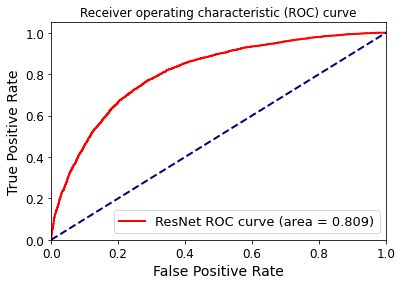

In [52]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ResNet ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

# Grid search for learning rate for ResNet

In [58]:
def build_model(lr_init=1.e-3, factors = 0.1):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=3, padding='same', kernel_initializer='glorot_normal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(DefaultConv2D(16, kernel_size=3, padding='same', kernel_initializer='glorot_normal'))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 64
    for filters in [16] * 1 + [32] * 2 + [64] * 1:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(MaxPooling2D(pool_size=3, strides=1, padding="SAME"))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=lr_init), metrics=['accuracy'])
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=factors, patience=2, min_lr=1.e-6)
    
    return model

In [61]:
lr_wrap = tensorflow.keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [62]:
param_distribs = {
    "factors":[0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6],
    "lr_init":[0.001, 0.005, 0.01, 0.05],
}

rnd_search_lr = RandomizedSearchCV(lr_wrap, param_distribs, cv = 3)

#exponential_decay_fn = exponential_decay(lr_init, s = 20) 
#lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)   
rnd_search_lr.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)

Train on 21333 samples, validate on 4000 samples
Epoch 1/20
21333/21333 [==============================] - 12s 543us/sample - loss: 0.6419 - accuracy: 0.6760 - val_loss: 1.0206 - val_accuracy: 0.5000
Epoch 2/20
21333/21333 [==============================] - 9s 424us/sample - loss: 0.5682 - accuracy: 0.7429 - val_loss: 0.8656 - val_accuracy: 0.5052
Epoch 3/20
21333/21333 [==============================] - 9s 405us/sample - loss: 0.5521 - accuracy: 0.7504 - val_loss: 0.7741 - val_accuracy: 0.5577
Epoch 4/20
21333/21333 [==============================] - 9s 400us/sample - loss: 0.5455 - accuracy: 0.7540 - val_loss: 0.7361 - val_accuracy: 0.5770
Epoch 5/20
21333/21333 [==============================] - 9s 403us/sample - loss: 0.5391 - accuracy: 0.7562 - val_loss: 0.7835 - val_accuracy: 0.5533
Epoch 6/20
21333/21333 [==============================] - 9s 400us/sample - loss: 0.5333 - accuracy: 0.7569 - val_loss: 0.7878 - val_accuracy: 0.5343
Epoch 7/20
21333/21333 [==========================

21334/21334 [==============================] - 9s 410us/sample - loss: 0.5334 - accuracy: 0.7493 - val_loss: 0.7123 - val_accuracy: 0.5000
Epoch 5/20
21334/21334 [==============================] - 9s 410us/sample - loss: 0.5288 - accuracy: 0.7490 - val_loss: 0.8756 - val_accuracy: 0.5000
Epoch 6/20
21334/21334 [==============================] - 9s 406us/sample - loss: 0.5254 - accuracy: 0.7489 - val_loss: 1.2033 - val_accuracy: 0.5000
Epoch 7/20
21334/21334 [==============================] - 9s 408us/sample - loss: 0.5126 - accuracy: 0.7491 - val_loss: 0.8082 - val_accuracy: 0.5415
Epoch 8/20
21334/21334 [==============================] - 9s 403us/sample - loss: 0.5048 - accuracy: 0.7493 - val_loss: 0.6787 - val_accuracy: 0.5000
Epoch 9/20
21334/21334 [==============================] - 9s 410us/sample - loss: 0.5000 - accuracy: 0.7488 - val_loss: 0.6910 - val_accuracy: 0.5232
Epoch 10/20
21334/21334 [==============================] - 9s 409us/sample - loss: 0.4954 - accuracy: 0.7490 - 

21333/21333 [==============================] - 9s 400us/sample - loss: 0.6403 - accuracy: 0.6339 - val_loss: 0.6563 - val_accuracy: 0.6090
Epoch 8/20
21333/21333 [==============================] - 9s 404us/sample - loss: 0.6351 - accuracy: 0.6390 - val_loss: 0.6747 - val_accuracy: 0.6035
Epoch 9/20
21333/21333 [==============================] - 9s 401us/sample - loss: 0.6191 - accuracy: 0.6579 - val_loss: 0.6522 - val_accuracy: 0.6205
Epoch 10/20
21333/21333 [==============================] - 9s 403us/sample - loss: 0.6113 - accuracy: 0.6668 - val_loss: 0.6781 - val_accuracy: 0.6133
Epoch 11/20
21333/21333 [==============================] - 9s 402us/sample - loss: 0.6020 - accuracy: 0.6734 - val_loss: 0.6661 - val_accuracy: 0.6220
Epoch 12/20
21333/21333 [==============================] - 9s 405us/sample - loss: 0.5754 - accuracy: 0.7014 - val_loss: 0.6703 - val_accuracy: 0.6158
Epoch 13/20
21333/21333 [==============================] - 9s 400us/sample - loss: 0.5590 - accuracy: 0.7144

21333/21333 [==============================] - 8s 367us/sample - loss: 0.4990 - accuracy: 0.7667 - val_loss: 1.5932 - val_accuracy: 0.5375
Epoch 11/20
21333/21333 [==============================] - 8s 390us/sample - loss: 0.4849 - accuracy: 0.7805 - val_loss: 0.9160 - val_accuracy: 0.5038
Epoch 12/20
21333/21333 [==============================] - 8s 361us/sample - loss: 0.4815 - accuracy: 0.7777 - val_loss: 0.9935 - val_accuracy: 0.5010
Epoch 13/20
21333/21333 [==============================] - 8s 363us/sample - loss: 0.4724 - accuracy: 0.7842 - val_loss: 0.6322 - val_accuracy: 0.6895
Epoch 14/20
21333/21333 [==============================] - 8s 361us/sample - loss: 0.4690 - accuracy: 0.7873 - val_loss: 0.8559 - val_accuracy: 0.5142
Epoch 15/20
21333/21333 [==============================] - 8s 362us/sample - loss: 0.4661 - accuracy: 0.7910 - val_loss: 0.6576 - val_accuracy: 0.6948
Epoch 16/20
21333/21333 [==============================] - 8s 360us/sample - loss: 0.4613 - accuracy: 0.79

21334/21334 [==============================] - 10s 457us/sample - loss: 0.4560 - accuracy: 0.7742 - val_loss: 1.1816 - val_accuracy: 0.5372
Epoch 14/20
21334/21334 [==============================] - 10s 459us/sample - loss: 0.4511 - accuracy: 0.7797 - val_loss: 0.8771 - val_accuracy: 0.5957
Epoch 15/20
21334/21334 [==============================] - 10s 462us/sample - loss: 0.4402 - accuracy: 0.7884 - val_loss: 0.7362 - val_accuracy: 0.5840
Epoch 16/20
21334/21334 [==============================] - 10s 466us/sample - loss: 0.4332 - accuracy: 0.7910 - val_loss: 0.8394 - val_accuracy: 0.6130
Epoch 17/20
21334/21334 [==============================] - 10s 467us/sample - loss: 0.4226 - accuracy: 0.7992 - val_loss: 0.7609 - val_accuracy: 0.6065
Epoch 18/20
21334/21334 [==============================] - 10s 465us/sample - loss: 0.4196 - accuracy: 0.8027 - val_loss: 0.8094 - val_accuracy: 0.5890
Epoch 19/20
21334/21334 [==============================] - 10s 463us/sample - loss: 0.4096 - accurac

21333/21333 [==============================] - 11s 514us/sample - loss: 0.5639 - accuracy: 0.7205 - val_loss: 0.6760 - val_accuracy: 0.5595
Epoch 17/20
21333/21333 [==============================] - 11s 515us/sample - loss: 0.5533 - accuracy: 0.7262 - val_loss: 0.5739 - val_accuracy: 0.7105
Epoch 18/20
21333/21333 [==============================] - 11s 514us/sample - loss: 0.5513 - accuracy: 0.7302 - val_loss: 0.6138 - val_accuracy: 0.6908
Epoch 19/20
21333/21333 [==============================] - 11s 513us/sample - loss: 0.5481 - accuracy: 0.7316 - val_loss: 0.7640 - val_accuracy: 0.6250
Epoch 20/20
10667/10667 [==============================] - 2s 232us/sample - loss: 0.5799 - accuracy: 0.6987
Train on 21334 samples, validate on 4000 samples
Epoch 1/20
21334/21334 [==============================] - 15s 711us/sample - loss: 0.5751 - accuracy: 0.7443 - val_loss: 0.8024 - val_accuracy: 0.5000
Epoch 2/20
21334/21334 [==============================] - 12s 566us/sample - loss: 0.5461 - acc

Epoch 7/20
21333/21333 [==============================] - 12s 564us/sample - loss: 0.6434 - accuracy: 0.6286 - val_loss: 0.6597 - val_accuracy: 0.6080
Epoch 8/20
21333/21333 [==============================] - 12s 566us/sample - loss: 0.6324 - accuracy: 0.6440 - val_loss: 0.7001 - val_accuracy: 0.5710
Epoch 9/20
21333/21333 [==============================] - 12s 566us/sample - loss: 0.6270 - accuracy: 0.6482 - val_loss: 0.6707 - val_accuracy: 0.6033
Epoch 10/20
21333/21333 [==============================] - 12s 566us/sample - loss: 0.6137 - accuracy: 0.6664 - val_loss: 0.6686 - val_accuracy: 0.6090
Epoch 11/20
21333/21333 [==============================] - 12s 567us/sample - loss: 0.6039 - accuracy: 0.6744 - val_loss: 0.6713 - val_accuracy: 0.6120
Epoch 12/20
21333/21333 [==============================] - 12s 565us/sample - loss: 0.5852 - accuracy: 0.6944 - val_loss: 0.6842 - val_accuracy: 0.6008
Epoch 13/20
21333/21333 [==============================] - 12s 566us/sample - loss: 0.5733 

RandomizedSearchCV(cv=3,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001DDF5AD4DC8>,
                   param_distributions={'factors': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                    0.55, 0.6],
                                        'lr_init': [0.001, 0.005, 0.01, 0.05]})

In [63]:
rnd_search_lr.best_params_

{'lr_init': 0.05, 'factors': 0.1}

# Model 4: Train the ResNet with optimized learning parameter

In [75]:
tensorflow.keras.backend.clear_session()
model = Sequential()
model.add(Conv2D(16, kernel_size=3, padding='same', kernel_initializer='glorot_normal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(DefaultConv2D(16, kernel_size=3, padding='same', kernel_initializer='glorot_normal'))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [16] * 1 + [32] * 2 + [64] * 1:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(MaxPooling2D(pool_size=3, strides=1, padding="SAME"))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.05), metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1.e-6)
#learning_schedule = 
history=model.fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)


Train on 256000 samples, validate on 40000 samples
Epoch 1/25
256000/256000 [==============================] - 153s 599us/sample - loss: 0.6337 - accuracy: 0.6510 - val_loss: 0.6822 - val_accuracy: 0.5662
Epoch 2/25
256000/256000 [==============================] - 151s 589us/sample - loss: 0.6017 - accuracy: 0.6912 - val_loss: 0.6020 - val_accuracy: 0.6904
Epoch 3/25
256000/256000 [==============================] - 151s 590us/sample - loss: 0.5902 - accuracy: 0.7020 - val_loss: 0.7775 - val_accuracy: 0.5091
Epoch 4/25
256000/256000 [==============================] - 150s 586us/sample - loss: 0.5852 - accuracy: 0.7053 - val_loss: 0.6373 - val_accuracy: 0.6738
Epoch 5/25
256000/256000 [==============================] - 156s 608us/sample - loss: 0.5628 - accuracy: 0.7194 - val_loss: 0.5967 - val_accuracy: 0.7260
Epoch 6/25
256000/256000 [==============================] - 155s 606us/sample - loss: 0.5581 - accuracy: 0.7228 - val_loss: 8.5761 - val_accuracy: 0.7263
Epoch 7/25
256000/256000 

In [76]:
# Evaluate on validation set
score = model.evaluate(X_valid, y_valid, verbose=1)
print('\nValidation loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_valid)
fpr, tpr, _ = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
print('Validation ROC AUC:', roc_auc)

# Evaluate on test set
score = model.evaluate(X_test, y_test, verbose=1)
print('\nTest loss / accuracy: %0.4f / %0.4f'%(score[0], score[1]))
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print('Test ROC AUC:', roc_auc)

40000/40000 [==============================] - 8s 205us/sample - loss: 0.5412 - accuracy: 0.7333

Validation loss / accuracy: 0.5412 / 0.7333
Validation ROC AUC: 0.80162424
40000/40000 [==============================] - 8s 191us/sample - loss: 0.5376 - accuracy: 0.7352

Test loss / accuracy: 0.5376 / 0.7352
Test ROC AUC: 0.80502400875


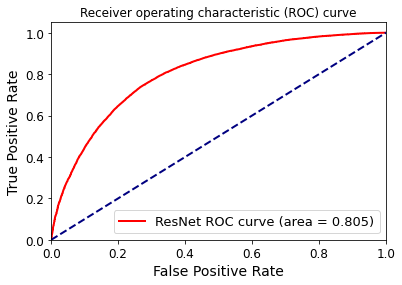

In [77]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ResNet ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

Using the optimized learning rate didn't improve the overall model performance. So, let's build an ensemble and check if we can enhance the performance.

# Model 5: Create an Ensemble of 50 ResNets

In [85]:
no_of_models = 50

model = [0] * no_of_models

for index in range(no_of_models):
    model[index] = Sequential()
    model[index].add(Conv2D(16, kernel_size=3, padding='same', kernel_initializer='glorot_normal', 
                 input_shape=(img_rows, img_cols, nb_channels)))
    model[index].add(BatchNormalization())
    model[index].add(Activation("relu"))
    model[index].add(DefaultConv2D(16, kernel_size=3, padding='same', kernel_initializer='glorot_normal'))
    model[index].add(BatchNormalization())
    model[index].add(Activation("relu"))
    model[index].add(MaxPooling2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 64
    for filters in [16] * 1 + [32] * 2 + [64] * 1:
        strides = 1 if filters == prev_filters else 2
        model[index].add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model[index].add(MaxPooling2D(pool_size=3, strides=1, padding="SAME"))
    model[index].add(Flatten())
    model[index].add(Dense(256, activation='relu'))
    model[index].add(BatchNormalization())
    model[index].add(Dropout(0.3))
    model[index].add(Dense(128, activation='relu'))
    model[index].add(BatchNormalization())
    model[index].add(Dropout(0.3))
    model[index].add(Dense(64, activation='relu'))
    model[index].add(BatchNormalization())
    model[index].add(Dropout(0.2))
    model[index].add(Dense(1, activation="sigmoid"))

    model[index].compile(loss='binary_crossentropy', optimizer=Adam(lr=0.05), metrics=['accuracy'])


#### Train 50 ResNets

In [86]:
history = [0] *no_of_models
epochs = 15

for j in range(no_of_models):
   reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1.e-6)
   history[j] = model[j].fit(X_train, y_train,\
        batch_size=batch_size,\
        epochs=epochs,\
        validation_data=(X_valid, y_valid),\
        callbacks=[reduce_lr],\
        verbose=1, shuffle=True)
  

Train on 256000 samples, validate on 40000 samples
Epoch 1/15
256000/256000 [==============================] - 122s 477us/sample - loss: 0.6442 - accuracy: 0.6369 - val_loss: 0.7189 - val_accuracy: 0.5113
Epoch 2/15
256000/256000 [==============================] - 120s 468us/sample - loss: 0.6027 - accuracy: 0.6905 - val_loss: 2.0652 - val_accuracy: 0.6148
Epoch 3/15
256000/256000 [==============================] - 120s 468us/sample - loss: 0.5895 - accuracy: 0.7032 - val_loss: 0.6035 - val_accuracy: 0.6956
Epoch 4/15
256000/256000 [==============================] - 119s 466us/sample - loss: 0.5891 - accuracy: 0.7022 - val_loss: 0.6012 - val_accuracy: 0.6952
Epoch 5/15
256000/256000 [==============================] - 120s 467us/sample - loss: 0.5812 - accuracy: 0.7096 - val_loss: 3.8298 - val_accuracy: 0.7090
Epoch 6/15
256000/256000 [==============================] - 119s 467us/sample - loss: 0.5873 - accuracy: 0.7035 - val_loss: 0.5911 - val_accuracy: 0.7211
Epoch 7/15
256000/256000 

256000/256000 [==============================] - 127s 498us/sample - loss: 0.5463 - accuracy: 0.7315 - val_loss: 0.5431 - val_accuracy: 0.7339
Epoch 15/15
256000/256000 [==============================] - 127s 497us/sample - loss: 0.5461 - accuracy: 0.7309 - val_loss: 0.5429 - val_accuracy: 0.7343
Train on 256000 samples, validate on 40000 samples
Epoch 1/15
256000/256000 [==============================] - 121s 471us/sample - loss: 0.6323 - accuracy: 0.6513 - val_loss: 0.8698 - val_accuracy: 0.5002
Epoch 2/15
256000/256000 [==============================] - 118s 461us/sample - loss: 0.6015 - accuracy: 0.6904 - val_loss: 0.6175 - val_accuracy: 0.6895
Epoch 3/15
256000/256000 [==============================] - 118s 460us/sample - loss: 0.5937 - accuracy: 0.7000 - val_loss: 1.2795 - val_accuracy: 0.5802
Epoch 4/15
256000/256000 [==============================] - 118s 460us/sample - loss: 0.5871 - accuracy: 0.7034 - val_loss: 9642.7221 - val_accuracy: 0.6444
Epoch 5/15
256000/256000 [======

256000/256000 [==============================] - 151s 591us/sample - loss: 0.5498 - accuracy: 0.7286 - val_loss: 0.5464 - val_accuracy: 0.7320
Epoch 12/15
256000/256000 [==============================] - 161s 630us/sample - loss: 0.5494 - accuracy: 0.7285 - val_loss: 0.5432 - val_accuracy: 0.7317
Epoch 13/15
256000/256000 [==============================] - 151s 588us/sample - loss: 0.5482 - accuracy: 0.7295 - val_loss: 0.5458 - val_accuracy: 0.7303
Epoch 14/15
256000/256000 [==============================] - 155s 607us/sample - loss: 0.5474 - accuracy: 0.7303 - val_loss: 58.0028 - val_accuracy: 0.7319
Epoch 15/15
256000/256000 [==============================] - 156s 611us/sample - loss: 0.5444 - accuracy: 0.7313 - val_loss: 3820.6905 - val_accuracy: 0.7338
Train on 256000 samples, validate on 40000 samples
Epoch 1/15
256000/256000 [==============================] - 157s 613us/sample - loss: 0.6374 - accuracy: 0.6450 - val_loss: 0.6861 - val_accuracy: 0.6791
Epoch 2/15
256000/256000 [==

KeyboardInterrupt: 

Since we were able to train only 17 ResNets, we will use them to make prediction.

In [97]:
Y_pred = np.zeros([len(X_test), 17], dtype=np.float16)

for j in range(17):
    prob_predict =model[j].predict(X_test)   # the predicted probabilites of a model are added
    Y_pred[:,j] = prob_predict.reshape([-1])

threshold = 0.5
Y_pred_class = np.where(Y_pred > threshold, 1 ,0)  # defining the class based on threshold probability

Use `scipy.stats.mode` to get the majority votes

In [98]:
from scipy.stats import mode
y_pred_majority_votes, n_votes = mode(Y_pred_class, axis = 1)

For each ResNet in the ensemble print the accuracy and also print the ensemble accuracy.

In [100]:
for j in range(17):
    los, accu = model[j].evaluate(X_test, y_test)
    print("ResNet {0}  Accuracy {1:.5f}".format(j+1, accu))
ensem_accu = accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))
print("The Ensemble accuracy is ", ensem_accu)

40000/40000 [==============================] - 14s 360us/sample - loss: 0.7517 - accuracy: 0.7368
ResNet 1  Accuracy 0.73675
40000/40000 [==============================] - 14s 358us/sample - loss: 0.5362 - accuracy: 0.7381
ResNet 2  Accuracy 0.73810
40000/40000 [==============================] - 15s 373us/sample - loss: 0.5450 - accuracy: 0.7305
ResNet 3  Accuracy 0.73048
40000/40000 [==============================] - 16s 389us/sample - loss: 0.5443 - accuracy: 0.7296
ResNet 4  Accuracy 0.72962
40000/40000 [==============================] - 16s 391us/sample - loss: 0.5413 - accuracy: 0.7344
ResNet 5  Accuracy 0.73445
40000/40000 [==============================] - 16s 397us/sample - loss: 0.5439 - accuracy: 0.7328
ResNet 6  Accuracy 0.73277
40000/40000 [==============================] - 14s 353us/sample - loss: 0.5385 - accuracy: 0.7354
ResNet 7  Accuracy 0.73537
40000/40000 [==============================] - 14s 360us/sample - loss: 0.5401 - accuracy: 0.7331
ResNet 8  Accuracy 0.73310


In [107]:
Y_pred_averaged = Y_pred.mean(axis=1)  # finding the average of predicted probabilities by each ResNet.
fpr, tpr, _ = roc_curve(y_test, Y_pred_averaged)  
roc_auc = auc(fpr, tpr)
print('Ensemble ROC AUC:', roc_auc)

Ensemble ROC AUC: 0.80804678125


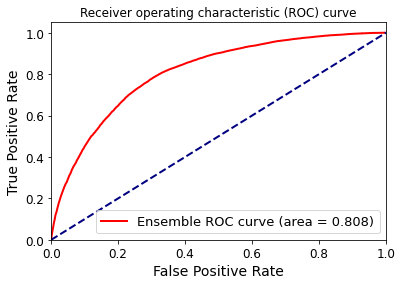

In [108]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='Ensemble ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right", fontsize=13)
plt.show()

The ensemble increased the accuracy and AUC only slightly.